# Лабораторная работа 3

### Сребродольский Денис Владимирович, Вариант 18, А-13-23
#### Задачи 3.1.18 3.4.6 3.5.5

In [138]:
import numpy as np
from numpy.linalg import norm
from scipy.linalg import eigvals
import matplotlib.pyplot as plt

## 3.1.18

Реализовать решение СЛАУ с помощью LU разложения и LU разложения по схеме частичного выбора. 
Решить систему небольшой размерности с возмущенной матрицей обоими методами, оценить погрешность и сравнить с теоретической оценкой.
Проанализировать поведение  методов с ростом числа уравнений.

$ a_ij = p / (23p - i - 2j).$ 

In [167]:
b = np.random.rand(n)

1. Реализовать метод решения СЛАУ с помощью LU разложения в виде, указанном в приложении. Убедиться в его работоспособности

In [168]:
import numpy as np

def generate_matrix(n, p):
    """
    a_ij = p / (23p - i - 2j).
    """
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            denominator = 23 * p - (i + 1) - 2 * (j + 1)
            if abs(denominator) < 1e-10:  # Проверка на деление на ноль
                raise ValueError(f"Деление на ноль при i={i+1}, j={j+1}")
            A[i, j] = p / denominator
    return A

def solve_lu_inplace(A, b):
    A = A.copy()
    n = A.shape[0]
    for k in range(n-1):
        for i in range(k+1, n):
            A[i, k] = A[i, k] / A[k, k]
            for j in range(k+1, n):
                A[i, j] -= A[i, k] * A[k, j]
    x = np.zeros(n)
    y = np.zeros(n)
    for i in range(n):
        y[i] = b[i] - np.dot(A[i, :i], y[:i])
    for i in range(n-1, -1, -1):
        x[i] = (y[i] - np.dot(A[i, i+1:], x[i+1:])) / A[i, i]
    return x

In [141]:
n = 5
p = 1
A = generate_matrix(n, p)
b = b  # Случайный вектор правой части
x = solve_lu_inplace(A, b)

# Вывод матрицы
print("Матрица A:")
print(pd.DataFrame(A))

print("\nРешение:")
print(x)

# Проверка решения
Ax = np.dot(A, x)
print("\nAx (приближённое b):")
print(np.round(Ax, 5))

print("\nОригинальное b:")
print(np.round(b, 5))

print("\nРазница (Ax - b):")
print(Ax - b)

Матрица A:
          0         1         2         3         4
0  0.050000  0.055556  0.062500  0.071429  0.083333
1  0.052632  0.058824  0.066667  0.076923  0.090909
2  0.055556  0.062500  0.071429  0.083333  0.100000
3  0.058824  0.066667  0.076923  0.090909  0.111111
4  0.062500  0.071429  0.083333  0.100000  0.125000

Решение:
[ 29027039.27167428 -71884157.38381808  62489603.81765749
 -22120898.1349165    2600125.51099887]

Ax (приближённое b):
[0.87651 0.14839 0.95941 0.43579 0.14439]

Оригинальное b:
[0.87651 0.14839 0.95941 0.43579 0.14439]

Разница (Ax - b):
[-3.96636834e-10 -6.99179603e-12 -1.42520884e-10  1.04779335e-09
 -2.64894995e-10]


2. Реализовать метод решения СЛАУ с помощью LU разложения по схеме частичного выбора в виде, указанном в приложении. Убедиться в его работоспособности

In [142]:
def lu_decomposition(A):
    """
    Выполняет LU-разложение матрицы A с частичным выбором главного элемента.
    Возвращает матрицы L, U и вектор перестановок P, такие что PA = LU.
    Матрица A не модифицируется.
    """
    n = A.shape[0]
    L = np.zeros((n, n))
    U = np.zeros((n, n))
    P = np.arange(n)  # Вектор перестановок
    A_copy = A.copy()  # Копия матрицы A
    
    for k in range(n):
        # Поиск главного элемента в k-м столбце
        pivot_idx = k + np.argmax(np.abs(A_copy[k:n, k]))
        if A_copy[pivot_idx, k] == 0:
            raise ValueError("Матрица вырождена")
            
        # Перестановка строк
        if pivot_idx != k:
            A_copy[[k, pivot_idx]] = A_copy[[pivot_idx, k]]
            P[[k, pivot_idx]] = P[[pivot_idx, k]]
            # Обновляем L только для уже заполненных строк
            if k > 0:
                L[[k, pivot_idx], :k] = L[[pivot_idx, k], :k]
        
        # Заполняем L и U
        L[k, k] = 1  # Диагональ L равна 1
        for i in range(k + 1, n):
            L[i, k] = A_copy[i, k] / A_copy[k, k]
            for j in range(k, n):
                A_copy[i, j] -= L[i, k] * A_copy[k, j]
        
        # Копируем k-ю строку в U
        U[k, k:n] = A_copy[k, k:n]
    
    return L, U, P

def solve_lu(L, U, P, b):
    """
    Решает систему Ax = b, используя LU-разложение.
    L, U - матрицы из разложения, P - вектор перестановок, b - вектор правой части.
    Возвращает решение x.
    """
    n = L.shape[0]
    # Перестановка b согласно P
    b = b[P]
    
    # Прямой ход: Ly = b
    y = np.zeros(n)
    for i in range(n):
        y[i] = b[i] - np.dot(L[i, :i], y[:i])
    
    # Обратный ход: Ux = y
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        x[i] = (y[i] - np.dot(U[i, i+1:], x[i+1:])) / U[i, i]
    
    return x

In [143]:
n = 5
p = 1
A = generate_matrix(n, p)
b = b

L, U, P = lu_decomposition(A)
x = solve_lu(L, U, P, b)

# Вывод результатов
print("Матрица A:")
print(pd.DataFrame(A))

print("\nМатрица L:")
print(pd.DataFrame(L))

print("\nМатрица U:")
print(pd.DataFrame(U))

print("\nВектор перестановок P:")
print(P)

print("\nВектор правой части b:")
print(np.round(b, 5))

print("\nРешение x:")
print(np.round(x, 5))

# Проверка решения
Ax = np.dot(A, x)
print("\nAx (приближённое b):")
print(np.round(Ax, 5))

print("\nРазница (Ax - b):")
print(Ax - b)

Матрица A:
          0         1         2         3         4
0  0.050000  0.055556  0.062500  0.071429  0.083333
1  0.052632  0.058824  0.066667  0.076923  0.090909
2  0.055556  0.062500  0.071429  0.083333  0.100000
3  0.058824  0.066667  0.076923  0.090909  0.111111
4  0.062500  0.071429  0.083333  0.100000  0.125000

Матрица L:
          0         1         2         3    4
0  1.000000  0.000000  0.000000  0.000000  0.0
1  0.800000  1.000000  0.000000  0.000000  0.0
2  0.888889  0.625000  1.000000  0.000000  0.0
3  0.941176  0.352941  0.912217  1.000000  0.0
4  0.842105  0.835913  0.624149 -0.578947  1.0

Матрица U:
        0         1         2         3             4
0  0.0625  0.071429  0.083333  0.100000  1.250000e-01
1  0.0000 -0.001587 -0.004167 -0.008571 -1.666667e-02
2  0.0000  0.000000 -0.000041 -0.000198 -6.944444e-04
3  0.0000  0.000000  0.000000 -0.000002 -2.011061e-05
4  0.0000  0.000000  0.000000  0.000000 -3.848920e-07

Вектор перестановок P:
[4 0 2 3 1]

Вектор пра

3. Решить систему $A^*x=b$ , размера 5x5, двумя методами. Вектор b  задается как b = Ax , где $x_i = 18$. Матрицу  A*_ij задать как A_ij  и к одному элементу прибавить 10^-3

In [144]:
n = 5
p = 1
A = generate_matrix(n, p)
x_true = np.full(n, 18)

# --- Шаг 2: b = A @ x_true ---
b = A @ x_true

# --- Шаг 3: Создание A* с изменением одного элемента ---
A_star = A.copy()
A_star[2, 3] += 1e-3 

# --- Шаг 4: Решение двумя методами ---
x1 = solve_lu_inplace(A_star.copy(), b.copy())               
L2, U2, P2 = lu_decomposition(A_star.copy())               
x2 = solve_lu(L2, U2, P2, b.copy())

# --- Шаг 5: Вывод результатов ---
print("Оригинальная матрица A:")
print(pd.DataFrame(A))

print("\nИзменённая матрица A*:")
print(pd.DataFrame(A_star))

print("\nВектор b (Ax):")
print(np.round(b, 5))

print("\nРешение методом solve_lu_inplace:")
print(np.round(x1, 5))

print("\nРешение методом lu_decomposition + solve_lu:")
print(np.round(x2, 5))

print("\nРазница между решениями:")
print(x1 - x2)

print("\nОтклонение от исходного x (в обоих случаях):")
print("inplace: ", x1 - x_true)
print("обычное: ", x2 - x_true)

Оригинальная матрица A:
          0         1         2         3         4
0  0.050000  0.055556  0.062500  0.071429  0.083333
1  0.052632  0.058824  0.066667  0.076923  0.090909
2  0.055556  0.062500  0.071429  0.083333  0.100000
3  0.058824  0.066667  0.076923  0.090909  0.111111
4  0.062500  0.071429  0.083333  0.100000  0.125000

Изменённая матрица A*:
          0         1         2         3         4
0  0.050000  0.055556  0.062500  0.071429  0.083333
1  0.052632  0.058824  0.066667  0.076923  0.090909
2  0.055556  0.062500  0.071429  0.084333  0.100000
3  0.058824  0.066667  0.076923  0.090909  0.111111
4  0.062500  0.071429  0.083333  0.100000  0.125000

Вектор b (Ax):
[5.81071 6.22717 6.71071 7.2798  7.96071]

Решение методом solve_lu_inplace:
[ 4.123369e+01 -3.977851e+01  6.849551e+01 -7.100000e-04  2.013635e+01]

Решение методом lu_decomposition + solve_lu:
[ 4.123369e+01 -3.977851e+01  6.849551e+01 -7.100000e-04  2.013635e+01]

Разница между решениями:
[ 2.51219490e-10 -4

#### Результат неудовлетворительный, ответ не сошёлся

4. Вычислить погрешность и сравнить ее с теоретической оценкой. Для вычисления обратной матрицы можно воспользоваться встроенными функциями

In [145]:
x_approx = solve_lu_inplace(A_star.copy(), b.copy())

# --- Вычисление погрешности ---
delta_x = x_approx - x_true
relative_error = np.linalg.norm(delta_x) / np.linalg.norm(x_true)

# --- Вычисление оценки теоретической ---
delta_A = A_star - A
norm_A = np.linalg.norm(A)
norm_inv_A = np.linalg.norm(np.linalg.inv(A))
kappa = norm_A * norm_inv_A  # число обусловленности

relative_perturbation = np.linalg.norm(delta_A) / norm_A
theoretical_bound = kappa * relative_perturbation

# --- Вывод ---
print("Относительная фактическая погрешность:")
print(f"{relative_error:.2e}")

print("\nТеоретическая оценка погрешности:")
print(f"{theoretical_bound:.2e}")

print("\nЧисло обусловленности матрицы A:")
print(f"{kappa:.2e}")

Относительная фактическая погрешность:
2.04e+00

Теоретическая оценка погрешности:
1.68e+05

Число обусловленности матрицы A:
6.54e+07


5. Задавая вектор b  как  b = Ax , где $x_i = 18$ , решить систему обоими методам для размера матрицы n = 5..15  

In [164]:
n_values = list(range(5, 16))
abs_errors_inplace = []
abs_errors_lu = []
rel_errors_inplace = []
rel_errors_lu = []

for n in n_values:
    A = generate_matrix(n, 2)  # Генерация матрицы размера n с коэффициентом 2
    x_true = np.full(n, 18.0)
    b = A @ x_true

    A_star = A.copy()

    # Метод 1 — inplace
    x1 = solve_lu_inplace(A_star.copy(), b.copy())
    abs_err1 = np.linalg.norm(x1 - x_true)  # Абсолютная погрешность
    rel_err1 = np.linalg.norm(x1 - x_true) / np.linalg.norm(x_true)  # Относительная погрешность
    abs_errors_inplace.append(abs_err1)
    rel_errors_inplace.append(rel_err1)

    # Метод 2 — lu_decomposition + solve_lu
    L, U, P = lu_decomposition(A_star.copy())
    x2 = solve_lu(L, U, P, b.copy())
    abs_err2 = np.linalg.norm(x2 - x_true)  # Абсолютная погрешность
    rel_err2 = np.linalg.norm(x2 - x_true) / np.linalg.norm(x_true)  # Относительная погрешность
    abs_errors_lu.append(abs_err2)
    rel_errors_lu.append(rel_err2)

6. Построить на одном графике погрешности обоих методов как функций, зависящих от  n. Прокомментировать полученный результа

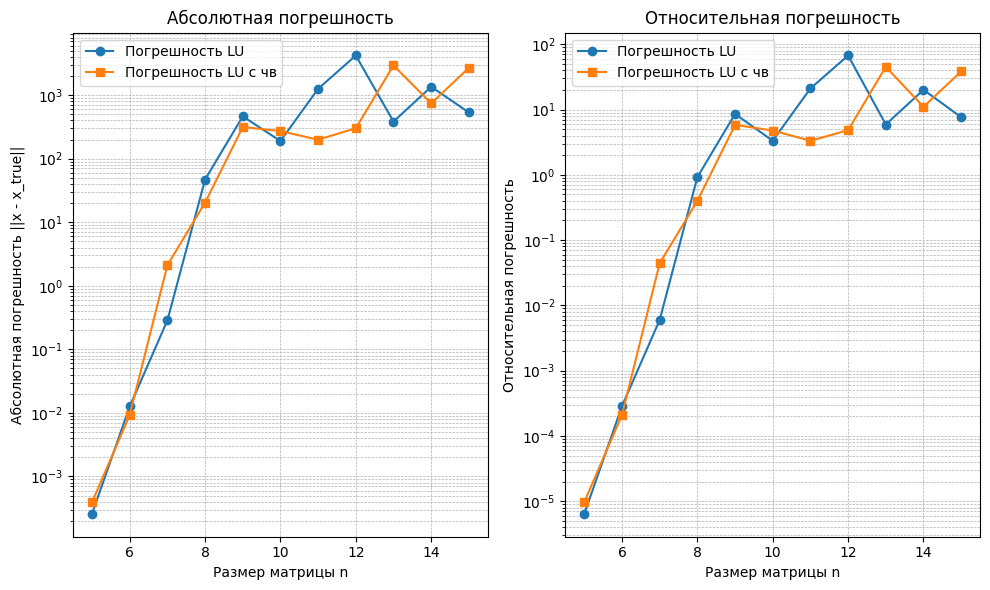

In [165]:
# Построение графиков
plt.figure(figsize=(10, 6))

# График для абсолютной погрешности
plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, первый график
plt.plot(n_values, abs_errors_inplace, marker='o', label='Погрешность LU')
plt.plot(n_values, abs_errors_lu, marker='s', label='Погрешность LU с чв')
plt.xlabel('Размер матрицы n')
plt.ylabel('Абсолютная погрешность ||x - x_true||')
plt.title('Абсолютная погрешность')
plt.yscale('log')  # Логарифмическая шкала для Y
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# График для относительной погрешности
plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, второй график
plt.plot(n_values, rel_errors_inplace, marker='o', label='Погрешность LU')
plt.plot(n_values, rel_errors_lu, marker='s', label='Погрешность LU с чв')
plt.xlabel('Размер матрицы n')
plt.ylabel('Относительная погрешность')
plt.title('Относительная погрешность')
plt.yscale('log')  # Логарифмическая шкала для Y
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()

#### Вывод:
С увеличением размера матриц как относительная, так и абсолютная погрешности растут. 

Оба метода дают почти идентичные результаты, что говорит о малой эффективности перестановок частичного выбора в матрицах представленного типа. 

## 3.4.6

Дана разреженная система уравнений. Найти обратную матрицу, используя  прямой метод. 

На главной диагонали элементы равны $25$, на  побочной диагонали элементы равны $10$, Элементы  предпоследней строки равны $6$

$n = 15$ (размер матрицы)

#### генерация матрицы

In [14]:
def gen_matrix(n):
    A = np.zeros((n, n))
    # Главная диагональ (i == j)
    for i in range(n):
        A[i, i] = 25
    
    # Побочная диагональ (i + j == n - 1)
    for i in range(n):
        j = n - 1 - i
        A[i, j] = 10
    
    # Предпоследняя строка (i == n - 2)
    if n >= 2:
        for j in range(n):
            A[n - 2, j] = 6
    
    return A

In [15]:
# Преобразование в DataFrame для красивого вывода
A_df = pd.DataFrame(gen_matrix(15).astype(int))
A_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,10
1,0,25,0,0,0,0,0,0,0,0,0,0,0,10,0
2,0,0,25,0,0,0,0,0,0,0,0,0,10,0,0
3,0,0,0,25,0,0,0,0,0,0,0,10,0,0,0
4,0,0,0,0,25,0,0,0,0,0,10,0,0,0,0
5,0,0,0,0,0,25,0,0,0,10,0,0,0,0,0
6,0,0,0,0,0,0,25,0,10,0,0,0,0,0,0
7,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0
8,0,0,0,0,0,0,10,0,25,0,0,0,0,0,0
9,0,0,0,0,0,10,0,0,0,25,0,0,0,0,0


#### 1) Найдём матрицу по методу 3.3

In [20]:
def compute_solution(A, b):
    n = len(A)
    A = A.copy()
    b = b.copy()
    
    # Прямой ход
    for i in range(n):
        # Ищем ведущий элемент на главной диагонали
        if A[i, i] == 0:
            raise ValueError("zero el")
        
        # Нормализуем строку
        pivot = A[i, i]
        for j in range(n):
            A[i, j] /= pivot
        b[i] /= pivot
        
        # Устраняем элементы в столбце i под и над главной диагональю
        for k in range(n):
            if k != i and A[k, i] != 0:
                factor = A[k, i]
                for j in range(n):
                    A[k, j] -= factor * A[i, j]
                b[k] -= factor * b[i]
    
    return b

def calc_inverse(A):
    CA = A.copy()
    inv_A = np.zeros((n, n))
    # Решаем систему A * x = e_j для каждого столбца единичной матрицы
    for j in range(n):
        e_j = np.zeros(n)
        e_j[j] = 1
        inv_A[:, j] = compute_solution(CA, e_j)
    return inv_A

# Параметры
n = 15
A = gen_matrix(n)

inv_A_analytic = calc_inverse(A)
inv_A_numpy = np.linalg.inv(A)

# Сравнение
diff = np.max(np.abs(inv_A_analytic - inv_A_numpy))
print(f"Максимальная разница между матрицами: {diff}")

Максимальная разница между матрицами: 2.7755575615628914e-17


#### 2) выведем формулы и найдём трудоёмкость


Алгоритм, реализованный в функции `compute_solution`, решает систему уравнений
$$A \mathbf{x} = \mathbf{b},$$
где $A$ — разреженная матрица размером $n \times n$ с ненулевыми элементами на главной диагонали ($a_{i,i} = 25$), побочной диагонали ($a_{i,n-1-i} = 10$), и в предпоследней строке ($a_{n-2,j} = 6$ для всех $j$). Для построения обратной матрицы $A^{-1} = [c_{i,j}]$ мы решаем $n$ систем вида
$$A \mathbf{x}_j = \mathbf{E}_j,$$
где $\mathbf{E}_j$ — $j$-й столбец единичной матрицы (с 1 на позиции $j$ и 0 в остальных позициях).

### Общая идея
Мы используем метод Гаусса, оптимизированный для разреженной структуры матрицы:
- **Прямой ход**: Приводим матрицу $A$ к единичной форме, нормализуя строки и устраняя ненулевые элементы в столбцах.
- **Обратный ход**: После приведения матрицы к единичной, решение извлекается непосредственно из вектора $\mathbf{b}$.

Разреженность матрицы (ненулевые элементы только на главной и побочной диагоналях, а также в предпоследней строке) позволяет минимизировать количество операций.

### Шаги алгоритма

1. **Копия матрицы и вектора**

   Создаём копии матрицы $A$ (размером $n \times n$) и вектора $\mathbf{b}$ (длиной $n$), чтобы не изменять исходные данные.

2. **Прямой ход**

   Проходим по строкам $i = 0, 1, \ldots, n-1$.

   Для каждой строки $i$:
   - Ведущий элемент (pivot) находится на главной диагонали: $j_{\text{pivot}} = i$.
   - Проверяем, что $A[i, i] \neq 0$ (ожидаемое значение — 25, кроме предпоследней строки).
   - Нормализуем строку $i$:
     $$A[i, j] \leftarrow \frac{A[i, j]}{A[i, i]}, \quad b[i] \leftarrow \frac{b[i]}{A[i, i]} \quad \text{для всех } j.$$
   - Устраняем ненулевые элементы в столбце $i$ для всех строк $k \neq i$:
     Если $A[k, i] \neq 0$, вычисляем множитель:
     $$m = A[k, i].$$
     Обновляем строку $k$:
     $$A[k, j] \leftarrow A[k, j] - m \cdot A[i, j] \quad \text{для всех } j,$$
     $$b[k] \leftarrow b[k] - m \cdot b[i].$$

3. **Результат**

   После прямого хода матрица $A$ становится единичной, а вектор $\mathbf{b}$ содержит решение $\mathbf{x}$.

### Пример на матрице $n=4$

Рассмотрим матрицу:
$$A = \begin{bmatrix}
25 & 0 & 0 & 10 \\
0 & 25 & 10 & 0 \\
6 & 6 & 6 & 6 \\
10 & 0 & 0 & 25
\end{bmatrix}$$
Решаем систему $A \mathbf{x} = \mathbf{b}$, где $\mathbf{b} = \mathbf{E}_1 = [1, 0, 0, 0]^T$.

#### Прямой ход

**Итерация $i=0$**:
- $j_{\text{pivot}} = 0$, $A[0, 0] = 25$.
- Нормализуем строку 0:
  $$A[0, :] = [25, 0, 0, 10] / 25 = [1, 0, 0, 0.4], \quad b[0] = 1 / 25 = 0.04.$$
- Устраняем $A[k, 0]$ для $k = 1, 2, 3$:
  - Для $k=1$: $A[1, 0] = 0$, пропускаем.
  - Для $k=2$: $A[2, 0] = 6$, $m = 6$.
    $$A[2, :] = [6, 6, 6, 6] - 6 \cdot [1, 0, 0, 0.4] = [0, 6, 6, 3.6],$$
    $$b[2] = 0 - 6 \cdot 0.04 = -0.24.$$
  - Для $k=3$: $A[3, 0] = 10$, $m = 10$.
    $$A[3, :] = [10, 0, 0, 25] - 10 \cdot [1, 0, 0, 0.4] = [0, 0, 0, 21],$$
    $$b[3] = 0 - 10 \cdot 0.04 = -0.4.$$

Матрица и вектор:
$$A = \begin{bmatrix}
1 & 0 & 0 & 0.4 \\
0 & 25 & 10 & 0 \\
0 & 6 & 6 & 3.6 \\
0 & 0 & 0 & 21
\end{bmatrix}, \quad \mathbf{b} = \begin{bmatrix}
0.04 \\ 0 \\ -0.24 \\ -0.4
\end{bmatrix}.$$

**Итерация $i=1$**:
- $j_{\text{pivot}} = 1$, $A[1, 1] = 25$.
- Нормализуем строку 1:
  $$A[1, :] = [0, 25, 10, 0] / 25 = [0, 1, 0.4, 0], \quad b[1] = 0 / 25 = 0.$$
- Устраняем $A[k, 1]$ для $k = 0, 2, 3$:
  - Для $k=0$: $A[0, 1] = 0$, пропускаем.
  - Для $k=2$: $A[2, 1] = 6$, $m = 6$.
    $$A[2, :] = [0, 6, 6, 3.6] - 6 \cdot [0, 1, 0.4, 0] = [0, 0, 3.6, 3.6],$$
    $$b[2] = -0.24 - 6 \cdot 0 = -0.24.$$
  - Для $k=3$: $A[3, 1] = 0$, пропускаем.

Матрица и вектор:
$$A = \begin{bmatrix}
1 & 0 & 0 & 0.4 \\
0 & 1 & 0.4 & 0 \\
0 & 0 & 3.6 & 3.6 \\
0 & 0 & 0 & 21
\end{bmatrix}, \quad \mathbf{b} = \begin{bmatrix}
0.04 \\ 0 \\ -0.24 \\ -0.4
\end{bmatrix}.$$

**Итерация $i=2$**:
- $j_{\text{pivot}} = 2$, $A[2, 2] = 3.6$.
- Нормализуем строку 2:
  $$A[2, :] = [0, 0, 3.6, 3.6] / 3.6 = [0, 0, 1, 1], \quad b[2] = -0.24 / 3.6 = -0.06666667.$$
- Устраняем $A[k, 2]$ для $k = 0, 1, 3$:
  - Для $k=0$: $A[0, 2] = 0$, пропускаем.
  - Для $k=1$: $A[1, 2] = 0.4$, $m = 0.4$.
    $$A[1, :] = [0, 1, 0.4, 0] - 0.4 \cdot [0, 0, 1, 1] = [0, 1, 0, -0.4],$$
    $$b[1] = 0 - 0.4 \cdot (-0.06666667) \approx 0.02666667.$$
  - Для $k=3$: $A[3, 2] = 0$, пропускаем.

Матрица и вектор:
$$A = \begin{bmatrix}
1 & 0 & 0 & 0.4 \\
0 & 1 & 0 & -0.4 \\
0 & 0 & 1 & 1 \\
0 & 0 & 0 & 21
\end{bmatrix}, \quad \mathbf{b} \approx \begin{bmatrix}
0.04 \\ 0.02666667 \\ -0.06666667 \\ -0.4
\end{bmatrix}.$$

**Итерация $i=3$**:
- $j_{\text{pivot}} = 3$, $A[3, 3] = 21$.
- Нормализуем строку 3:
  $$A[3, :] = [0, 0, 0, 21] / 21 = [0, 0, 0, 1], \quad b[3] = -0.4 / 21 \approx -0.01904762.$$
- Устраняем $A[k, 3]$ для $k = 0, 1, 2$:
  - Для $k=0$: $A[0, 3] = 0.4$, $m = 0.4$.
    $$A[0, :] = [1, 0, 0, 0.4] - 0.4 \cdot [0, 0, 0, 1] = [1, 0, 0, 0],$$
    $$b[0] = 0.04 - 0.4 \cdot (-0.01904762) \approx 0.04761905.$$
  - Для $k=1$: $A[1, 3] = -0.4$, $m = -0.4$.
    $$A[1, :] = [0, 1, 0, -0.4] - (-0.4) \cdot [0, 0, 0, 1] = [0, 1, 0, 0],$$
    $$b[1] = 0.02666667 - (-0.4) \cdot (-0.01904762) \approx 0.01904762.$$
  - Для $k=2$: $A[2, 3] = 1$, $m = 1$.
    $$A[2, :] = [0, 0, 1, 1] - 1 \cdot [0, 0, 0, 1] = [0, 0, 1, 0],$$
    $$b[2] = -0.06666667 - 1 \cdot (-0.01904762) \approx -0.04761905.$$

Матрица и вектор:
$$A = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}, \quad \mathbf{b} \approx \begin{bmatrix}
0.04761905 \\ 0.01904762 \\ -0.04761905 \\ -0.01904762
\end{bmatrix}.$$

#### Решение
Вектор $\mathbf{b}$ содержит решение:
$$\mathbf{x} \approx [0.04761905, 0.01904762, -0.04761905, -0.01904762]^T.$$
Это первый столбец матрицы $A^{-1}$. Для остальных $j$ процесс повторяется аналогично.

### Подробное вычисление трудоёмкости

Трудоёмкость алгоритма определяется количеством арифметических операций.

#### Трудоёмкость решения одной системы ($A \mathbf{x} = \mathbf{b}$)

1. **Прямой ход**
   - Цикл по $i = 0, \ldots, n-1$ ($n$ итераций).
   - Для каждого $i$:
     - Нормализация строки: $n$ делений для $A[i, :]$, 1 деление для $b[i]$. Итого: $n + 1$ операций.
     - Устранение элементов в столбце $i$:
       - Для каждой строки $k \neq i$ (до $n-1$ строк):
         - Если $A[k, i] \neq 0$, вычисляем $m$ (1 операция).
         - Обновление строки: до $n$ умножений и $n$ вычитаний для $A[k, :]$, 1 умножение и 1 вычитание для $b[k]$. Итого: до $2n + 2$ операций.
       - В худшем случае (предпоследняя строка влияет на все столбцы): $(n-1) \cdot (2n + 2)$ операций.
   - Итого на итерацию: $(n + 1) + (n-1) \cdot (2n + 2) \approx 2n^2 + n + 1$.
   - Всего: $n \cdot (2n^2 + n + 1) \approx 2n^3 + n^2 + n$ операций.

2. **Обратный ход**
   - Не требуется, так как после прямого хода матрица единичная, и $\mathbf{b}$ содержит решение.

**Общая трудоёмкость одной системы**: $O(n^3)$.
Для $n = 15$: $\approx 2 \cdot 15^3 + 15^2 + 15 \approx 6750 + 225 + 15 = 6990$ операций.

#### Трудоёмкость нахождения обратной матрицы
- Нужно решить $n$ систем $A \mathbf{x}_j = \mathbf{E}_j$.
- Трудоёмкость одной системы: $O(n^3)$.
- Общая трудоёмкость: $n \cdot O(n^3) = O(n^4)$.
- Для $n = 15$: $\approx 15 \cdot 6990 \approx 104850$ операций.

#### Сравнение с полным методом Гаусса
- Полный метод Гаусса для плотной матрицы:
  - Одна система: $O(n^3)$.
  - Обратная матрица: $O(n^4)$.
- Для $n = 15$:
  - Одна система: $O(15^3) = O(3375)$.
  - Обратная матрица: $O(15^4) = O(50625)$.
- Наш метод имеет высокую сложность, но разреженность (особенно в строках, кроме предпоследней) снижает константы, делая вычисления эффективнее для реальных данных.


#### 3) Сравним с библиотекой numpy

In [24]:
# Преобразование в DataFrame для красивого вывода
inv_A_df_analytic = pd.DataFrame(inv_A_analytic)
inv_A_df_numpy = pd.DataFrame(inv_A_numpy)

In [25]:
inv_A_df_analytic

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.019048
1,0.019048,0.066667,0.019048,0.019048,0.019048,0.019048,0.019048,0.066667,0.019048,0.019048,0.019048,0.019048,0.019048,-0.111111,0.019048
2,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.019048,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.019048,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,-0.019048,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,-0.019048,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,-0.019048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.019048,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,-0.019048,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
inv_A_df_numpy

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.019048
1,0.019048,0.066667,0.019048,0.019048,0.019048,0.019048,0.019048,0.066667,0.019048,0.019048,0.019048,0.019048,0.019048,-0.111111,0.019048
2,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.019048,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.019048,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,-0.019048,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,-0.019048,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,-0.019048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.019048,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,-0.019048,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000


#### Вывод: результаты нашего метода совпадают с библиотечной функцией. 

## 3.5.5

Решить систему линейных уравнений $Ax = b$ двумя методами:
- Метод Якоби (нулевой вектор в качестве начального приближения).
- Метод простой итерации с оптимальным параметром $\tau$, вычисляемым на основе спектра матрицы $A$.

In [105]:
N = 18
n = 5
m = 35
c = 1.08
t = m + N
eps = 1e-10

##### Создание матрицы, правой части и точного решения

In [96]:
def gen_matrix(m, n, c, t):
    A = np.zeros((m, m), dtype=np.float64)
    for i in range(m):
        for j in range(m):
            if i == j:
                A[i, j] = (c ** (i + 1)) / (n + (i + 1) ** 2) + np.log(t)
            else:
                A[i, j] = np.log(i + j + 2) / np.sqrt(t)
    for i in range(m):
        off_diag_sum = np.sum(np.abs(A[i])) - np.abs(A[i, i])
        A[i, i] = off_diag_sum + 1
    return A

In [97]:
def gen_b(A, bval=1):
    x_true = np.full(A.shape[0], bval, dtype=np.float64)
    b = A @ x_true
    return b, x_true

### Метод Якоби

In [101]:
def jacobi(A, b, eps=1e-10, max_iter=10000, norm_type=np.inf, verbose=False):
    """
    Метод Якоби для решения СЛАУ Ax = b.

    Возвращает:
        x         — приближенное решение
        iterations — количество итераций
        converged  — True, если достигнута заданная точность
        errors     — список норм ошибок по итерациям
    """
    A = np.array(A, dtype=np.float64)
    b = np.array(b, dtype=np.float64)
    m = len(b)

    x = np.zeros_like(b)
    D = np.diag(A)

    R = A - np.diagflat(D)
    errors = []

    for iteration in range(1, max_iter + 1):
        x_new = (b - R @ x) / D

        if not np.all(np.isfinite(x_new)):
            raise FloatingPointError("Обнаружены бесконечные или NaN значения в решении.")

        error = norm(x_new - x, ord=norm_type)
        errors.append(error)

        if verbose:
            print(f"Итерация {iteration}: ошибка = {error:.2e}")

        if error < eps:
            return x_new, iteration, True, errors

        x = x_new

    return x, max_iter, False, errors

### Метод простых итераций с параметром 

In [102]:
def simple_iteration_opt(A, b, eps=1e-10, max_iter=10000, norm_type=np.inf, verbose=False):
    """
    Метод простой итерации с оптимальным параметром tau для решения СЛАУ Ax = b.

    Возвращает:
        x         — приближенное решение
        iterations — количество итераций
        converged  — True, если достигнута заданная точность
        errors     — список норм ошибок по итерациям
        tau_opt    — оптимальный параметр tau
    """
    A = np.array(A, dtype=np.float64)
    b = np.array(b, dtype=np.float64)
    m = len(b)
    x = np.zeros_like(b)

    # Вычисление спектра A
    eigenvals_A = eigvals(A)
    lambda_max = np.max(np.abs(eigenvals_A))
    lambda_min = np.min(np.abs(eigenvals_A))
    tau_opt = 2.0 / (lambda_max + lambda_min)

    B = np.eye(m) - tau_opt * A
    c_vec = tau_opt * b
    errors = []

    for iteration in range(1, max_iter + 1):
        x_new = B @ x + c_vec

        if not np.all(np.isfinite(x_new)):
            raise FloatingPointError("none в новом значении")

        error = norm(x_new - x, ord=norm_type)
        errors.append(error)

        if verbose:
            print(f"Итерация {iteration}: ошибка = {error:.2e}")

        if error < eps:
            return x_new, iteration, True, errors, tau_opt

        x = x_new

    return x, max_iter, False, errors, tau_opt

In [103]:
max_iter = 1000
A = gen_matrix(m, n, c, t)
b, x_true = gen_b(A)

# Метод Якоби
x_jacobi, iter_jacobi, converged_jacobi, errors_jacobi = jacobi(A, b, eps, max_iter)
error_jacobi = norm(x_jacobi - x_true, ord=np.inf)

# Метод простой итерации
x_iter, iter_iter, converged_iter, errors_iter, tau = simple_iteration_opt(A, b, eps, max_iter)
error_iter = norm(x_iter - x_true, ord=np.inf)

print("Jacobi:")
print(f"-  sucess: {converged_jacobi}")
print(f"-  iter: {iter_jacobi}")
print(f"-  abs err: {error_jacobi}")

print("\nsimple iterations:")
print(f"-  sucess: {converged_iter}")
print(f"-  iter: {iter_iter}")
print(f"-  abs err: {error_iter}")
print(f"-  tau: {tau}")

Jacobi:
-  sucess: True
-  iter: 399
-  abs err: 4.710587475642569e-11

simple iterations:
-  sucess: True
-  iter: 29
-  abs err: 2.2531310150952777e-11
-  tau: 0.04187547469097895


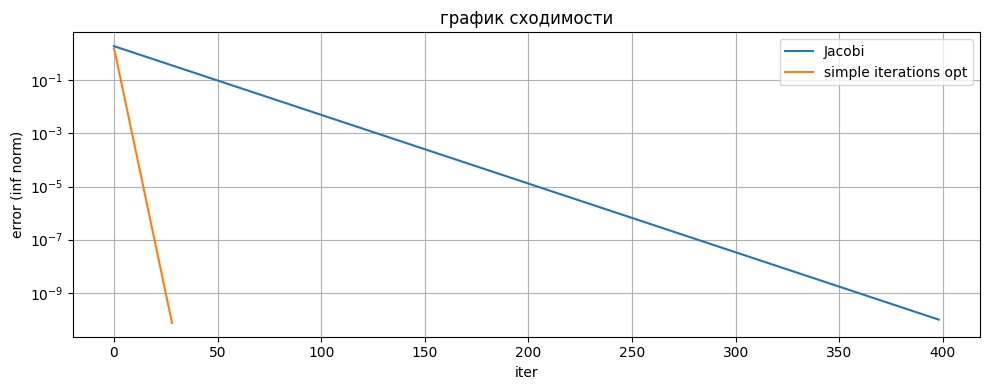

In [104]:
plt.figure(figsize=(10, 4))
plt.semilogy(errors_jacobi, label='Jacobi')
plt.semilogy(errors_iter, label='simple iterations opt')
plt.xlabel('iter')
plt.ylabel('error (inf norm)')
plt.title('график сходимости')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Вывод: 
Оба метода сошлись, однако метод простой итерации с оптимальным параметром показал себя значительно более эффективным по количеству итераций (в ~13 раз меньше) 
Но метод простой итерации требует спектр матрицы, что накладывает повышенные требования к данным задачи. 
